# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### lightgbm deberta-large 5folds (nestimatorふやしてみた)

In [1]:
! nvidia-smi

Sun May  8 05:09:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[0]
    train=True

    name = "exp003" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
COLAB = "google.colab" in sys.modules

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=0bfea1928cde53103be257953458d9cc7e0f4f8148e4c6c48f4213f2ef4938ee
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 880 kB 61.3 MB/s 
     |████████████████████████████████| 6.6 MB 54.0 MB/s 
     |████████████████████████████████| 77 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 52.9 MB/s 
     |████████████████████████████████| 1.2 MB 59.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=903092dd24d1ab0277b647c5273fd13a2f514386ff8124663f91122196d44688
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [11]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    if COLAB:
        cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
    else:
        cpcpath = '../input/cpc-data/CPCSchemeXML202105'
    for file_name in os.listdir(cpcpath):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        if COLAB:
            cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
        else:
            cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
        with open(cpcpath) as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [12]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

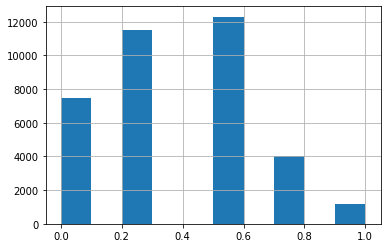

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    7295
1    7295
2    7295
3    7294
4    7294
dtype: int64

In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [20]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

# Helpler functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [23]:
### lightgbm
### 適当なやつ
def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    from lightgbm import LGBMRegressor
    model.eval()

    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
#     'max_depth': 5,
    # 'min_data_in_leaf': 50,   # default = 20
    # 'verbosity': -1,
    }
    

    train_data = lgb.Dataset(
        data=embeds, 
        label=targets, 
    )

    bst = lgb.train(params=params, 
                    train_set=train_data, 
                    num_boost_round=300)

    return bst

def valid_fn_(valid_loader, model, criterion, device, gbdt):
    model.eval()
    preds = []
    embeds = []
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            _, embed = model(inputs)
        y_preds = gbdt.predict(embed.to('cpu').numpy())
        preds.append(y_preds)

    predictions = np.concatenate(preds)
#     predictions = np.concatenate(predictions)
    return predictions


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # lightgbm train
        gbdt = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        predictions = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds


========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1823] Elapsed 0m 1s (remain 42m 45s) Loss: 0.6960(0.6960) Grad: 85358.2891  LR: 0.00002000  
Epoch: [1][100/1823] Elapsed 1m 36s (remain 27m 20s) Loss: 0.6153(0.6372) Grad: 27711.9453  LR: 0.00001999  
Epoch: [1][200/1823] Elapsed 3m 10s (remain 25m 38s) Loss: 0.5703(0.6138) Grad: 52638.1992  LR: 0.00001996  
Epoch: [1][300/1823] Elapsed 4m 45s (remain 24m 1s) Loss: 0.5873(0.5996) Grad: 23540.3711  LR: 0.00001992  
Epoch: [1][400/1823] Elapsed 6m 19s (remain 22m 25s) Loss: 0.6648(0.5906) Grad: 59175.8750  LR: 0.00001985  
Epoch: [1][500/1823] Elapsed 7m 53s (remain 20m 50s) Loss: 0.6343(0.5822) Grad: 15353.7891  LR: 0.00001977  
Epoch: [1][600/1823] Elapsed 9m 28s (remain 19m 15s) Loss: 0.4908(0.5774) Grad: 15361.2090  LR: 0.00001967  
Epoch: [1][700/1823] Elapsed 11m 2s (remain 17m 40s) Loss: 0.4902(0.5741) Grad: 38390.6992  LR: 0.00001955  
Epoch: [1][800/1823] Elapsed 12m 37s (remain 16m 6s) Loss: 0.5606(0.5720) Grad: 44276.9805  LR: 0.00001941  
Epoch: [1][900/1823] El

Epoch 1 - Score: 0.8485


Epoch: [2][0/1823] Elapsed 0m 1s (remain 36m 29s) Loss: 0.5422(0.5422) Grad: 122135.8203  LR: 0.00001707  
Epoch: [2][100/1823] Elapsed 1m 35s (remain 27m 13s) Loss: 0.4589(0.5241) Grad: 122515.9531  LR: 0.00001676  
Epoch: [2][200/1823] Elapsed 3m 10s (remain 25m 36s) Loss: 0.5371(0.5251) Grad: 93468.4688  LR: 0.00001643  
Epoch: [2][300/1823] Elapsed 4m 44s (remain 23m 59s) Loss: 0.3915(0.5212) Grad: 41188.0039  LR: 0.00001610  
Epoch: [2][400/1823] Elapsed 6m 19s (remain 22m 24s) Loss: 0.4923(0.5223) Grad: 94595.7422  LR: 0.00001575  
Epoch: [2][500/1823] Elapsed 7m 53s (remain 20m 49s) Loss: 0.5488(0.5220) Grad: 32310.8535  LR: 0.00001539  
Epoch: [2][600/1823] Elapsed 9m 27s (remain 19m 14s) Loss: 0.6223(0.5218) Grad: 87874.4766  LR: 0.00001503  
Epoch: [2][700/1823] Elapsed 11m 2s (remain 17m 39s) Loss: 0.5181(0.5221) Grad: 28729.7070  LR: 0.00001465  
Epoch: [2][800/1823] Elapsed 12m 36s (remain 16m 5s) Loss: 0.4971(0.5212) Grad: 44001.4805  LR: 0.00001426  
Epoch: [2][900/1823]

Epoch 2 - Score: 0.8597


Epoch: [3][0/1823] Elapsed 0m 1s (remain 37m 36s) Loss: 0.4920(0.4920) Grad: 153031.5625  LR: 0.00001000  
Epoch: [3][100/1823] Elapsed 1m 35s (remain 27m 12s) Loss: 0.5228(0.5058) Grad: 36043.8398  LR: 0.00000957  
Epoch: [3][200/1823] Elapsed 3m 10s (remain 25m 34s) Loss: 0.4250(0.5148) Grad: 185849.5312  LR: 0.00000914  
Epoch: [3][300/1823] Elapsed 4m 44s (remain 23m 58s) Loss: 0.4844(0.5122) Grad: 93079.1953  LR: 0.00000871  
Epoch: [3][400/1823] Elapsed 6m 18s (remain 22m 23s) Loss: 0.5845(0.5103) Grad: 35701.2109  LR: 0.00000829  
Epoch: [3][500/1823] Elapsed 7m 53s (remain 20m 48s) Loss: 0.4617(0.5115) Grad: 35929.5938  LR: 0.00000786  
Epoch: [3][600/1823] Elapsed 9m 27s (remain 19m 13s) Loss: 0.4470(0.5081) Grad: 91570.1172  LR: 0.00000744  
Epoch: [3][700/1823] Elapsed 11m 2s (remain 17m 39s) Loss: 0.4354(0.5082) Grad: 55286.7383  LR: 0.00000703  
Epoch: [3][800/1823] Elapsed 12m 36s (remain 16m 5s) Loss: 0.4833(0.5077) Grad: 168285.1875  LR: 0.00000662  
Epoch: [3][900/1823

Epoch 3 - Score: 0.8640


Epoch: [4][0/1823] Elapsed 0m 1s (remain 37m 10s) Loss: 0.4738(0.4738) Grad: 28273.6367  LR: 0.00000293  
Epoch: [4][100/1823] Elapsed 1m 35s (remain 27m 13s) Loss: 0.5483(0.4990) Grad: 94446.2500  LR: 0.00000263  
Epoch: [4][200/1823] Elapsed 3m 10s (remain 25m 34s) Loss: 0.5061(0.5003) Grad: 32774.7344  LR: 0.00000235  
Epoch: [4][300/1823] Elapsed 4m 44s (remain 23m 58s) Loss: 0.4610(0.4992) Grad: 67384.8438  LR: 0.00000208  
Epoch: [4][400/1823] Elapsed 6m 18s (remain 22m 23s) Loss: 0.5605(0.5002) Grad: 27592.7129  LR: 0.00000182  
Epoch: [4][500/1823] Elapsed 7m 53s (remain 20m 48s) Loss: 0.6409(0.4993) Grad: 60956.1875  LR: 0.00000158  
Epoch: [4][600/1823] Elapsed 9m 27s (remain 19m 14s) Loss: 0.4994(0.5012) Grad: 341585.6250  LR: 0.00000136  
Epoch: [4][700/1823] Elapsed 11m 1s (remain 17m 39s) Loss: 0.4399(0.5005) Grad: 21598.7793  LR: 0.00000115  
Epoch: [4][800/1823] Elapsed 12m 36s (remain 16m 5s) Loss: 0.4140(0.4998) Grad: 24644.1211  LR: 0.00000096  
Epoch: [4][900/1823] 

Epoch 4 - Score: 0.8647
========== fold: 0 result ==========
Score: 0.8647
========== CV ==========
Score: 0.8647


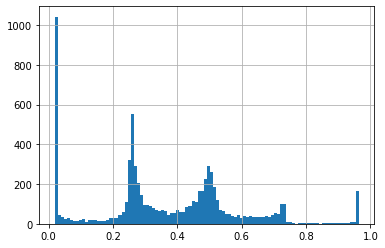

In [24]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()